<a href="https://colab.research.google.com/github/chasubeen/ML_lab/blob/main/3_HMM/3_HMM_BW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# **1. Preprocessing**

## **1-1. Load data**
- CoNLL-2000 file을 읽어와 word($\mathbf x$)와 tag($\mathbf z$) 처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data path

train_path = "/content/drive/MyDrive/ML_lab/3_HMM/data/train.txt"
test_path = "/content/drive/MyDrive/ML_lab/3_HMM/data/test.txt"

In [ ]:
### Read file

def read_file(path):
  raw = open(path, 'r').read().strip().split('\n\n')  # 빈 줄로 구분된 각 문장 처리
  words, tags = [], []

  for sentence in raw:
    lines = sentence.strip().split('\n')  # 문장 내의 각 라인(단어) 처리
    for line in lines:
      parts = line.split()  # 열 분할

      if len(parts) == 3:
        word, pos, chunk = parts
        words.append(word.lower())  # 소문자로 변환
        tags.append(pos)

    # 문장의 끝이라면(단어가 없다면) EOS 태그 추가
    if words:
      words.append('eos')
      tags.append('<EOS>')

  return words, tags

In [ ]:
train_words, train_tags = read_file(train_path)
test_words, test_tags = read_file(test_path)

## **1-2. Preprocess Data**

### **a) 특수 문자 처리**
- 숫자 태그를 'NUM'으로 변경
- 빈 문자열 제거

In [ ]:
def preprocessing(words, tags):
  processed_words = []
  processed_tags = []

  for word, tag in zip(words, tags):

    # 모든 숫자의 tag는 'NUM'으로 대체
    if re.match(r'^[0-9]*$', word):
      tag = 'NUM'

    # 빈 문자열이 아닌 경우에만 추가
    if word.strip():
      processed_words.append(word.lower())  # 소문자 변환
      processed_tags.append(tag)

  return processed_words, processed_tags

In [ ]:
train_words, train_tags = preprocessing(train_words, train_tags)
test_words, test_tags = preprocessing(test_words, test_tags)

### **b) POS Tag 통합**
- 영어의 대표적인 **8품사(+ 접속사, 숫자)**만 남기고, 나머지는 기타로 처리

In [ ]:
def modify_tags(tags):
  modified_tags = []

  for tag in tags:
    if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
      modified_tags.append('N')

    elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
      modified_tags.append('V')

    elif tag in ['PRP', 'PRP$']:
      modified_tags.append('PN')

    elif tag in ['IN']:
      modified_tags.append('PP')

    elif tag in ['RB', 'RBR', 'RBS', 'WRB']:
      modified_tags.append('AD')

    elif tag in ['CC']:
      modified_tags.append('CONJ')

    elif tag in ['DT', 'PDT']:
      modified_tags.append('ART')

    elif tag in ['JJ', 'JJR', 'JJS']:
      modified_tags.append('AdJ')

    elif tag in ['NUM']:
      modified_tags.append('NUM')
    elif tag in ['<EOS>']:
      modified_tags.append('<EOS>')
    else:
      modified_tags.append('ETC')

  return modified_tags

In [ ]:
train_tags = modify_tags(train_tags)
test_tags = modify_tags(test_tags)

In [ ]:
print(len(set(train_tags)))
print(len(set(test_tags)))

11
11


In [ ]:
set(train_tags)

{'<EOS>', 'AD', 'ART', 'AdJ', 'CONJ', 'ETC', 'N', 'NUM', 'PN', 'PP', 'V'}

> **11**개의 tag(품사)로 잘 정리된 것을 확인할 수 있다.

### **c) 단어 사전 생성**
- 태그와 단어들을 인덱스로 매핑하는 사전 생성

In [ ]:
def make_dict(tags, words):
  tag_to_index = {tag: idx for idx, tag in enumerate(set(tags))}
  word_to_index = {word: idx for idx, word in enumerate(set(words))}
  return tag_to_index, word_to_index

In [ ]:
tag_to_index, vocab_to_index = make_dict(train_tags, train_words)

In [ ]:
tag_to_index

{'AD': 0,
 'CONJ': 1,
 'PP': 2,
 'V': 3,
 'AdJ': 4,
 '<EOS>': 5,
 'PN': 6,
 'NUM': 7,
 'ART': 8,
 'N': 9,
 'ETC': 10}

In [ ]:
# UNK(Unknown) 추가
vocab_to_index['UNK'] = len(vocab_to_index)

### **d) index 변환**

In [ ]:
def to_indices(objs, obj_to_idx):
  return [obj_to_idx.get(obj, obj_to_idx['UNK']) for obj in objs]

In [ ]:
train_data_idx = to_indices(train_words, vocab_to_index)
train_tag_idx = [tag_to_index[tag] for tag in train_tags]

In [ ]:
test_data_idx = to_indices(test_words, vocab_to_index)
test_tag_idx = [tag_to_index[tag] for tag in test_tags]

## **1-3. 최종 데이터 확인**

In [ ]:
print(train_tags[:40])
print()
print(train_words[:40])

['N', 'PP', 'ART', 'N', 'V', 'AD', 'V', 'ETC', 'V', 'ART', 'AdJ', 'N', 'PP', 'N', 'N', 'PP', 'N', 'ETC', 'AdJ', 'PP', 'N', 'N', 'ETC', 'V', 'ETC', 'V', 'ART', 'AdJ', 'N', 'PP', 'N', 'CONJ', 'N', 'ETC', 'AdJ', 'N', 'ETC', '<EOS>', 'N', 'PP']

['confidence', 'in', 'the', 'pound', 'is', 'widely', 'expected', 'to', 'take', 'another', 'sharp', 'dive', 'if', 'trade', 'figures', 'for', 'september', ',', 'due', 'for', 'release', 'tomorrow', ',', 'fail', 'to', 'show', 'a', 'substantial', 'improvement', 'from', 'july', 'and', 'august', "'s", 'near-record', 'deficits', '.', 'eos', 'chancellor', 'of']


# **2. Modeling**

In [ ]:
class HMM_BaumWelch:
  def __init__(self, n_states, n_observations):
    self.n_states = n_states
    self.n_observations = n_observations

    self.A = np.random.rand(n_states, n_states)
    self.A /= self.A.sum(axis=1, keepdims=True)

    self.B = np.random.rand(n_states, n_observations)
    self.B /= self.B.sum(axis=1, keepdims=True)

    self.pi = np.random.rand(n_states)
    self.pi /= self.pi.sum()

  def forward(self, observations):
    T = len(observations)
    alpha = np.zeros((T, self.n_states))

    alpha[0] = self.pi * self.B[:, observations[0]]
    alpha[0] /= alpha[0].sum()

    for t in range(1, T):
      for j in range(self.n_states):
        alpha[t, j] = np.sum(alpha[t-1] * self.A[:, j]) * self.B[j, observations[t]]
      alpha[t] /= alpha[t].sum()

    return alpha

  def backward(self, observations):
    T = len(observations)
    beta = np.zeros((T, self.n_states))

    beta[T-1] = 1

    for t in range(T-2, -1, -1):
      for i in range(self.n_states):
        beta[t, i] = np.sum(self.A[i] * self.B[:, observations[t+1]] * beta[t+1])
      beta[t] /= beta[t].sum()

    return beta

  def calculate_gamma(self, alpha, beta):
    gamma = alpha * beta
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

  def calculate_xi(self, observations, alpha, beta):
    T = len(observations)
    xi = np.zeros((T-1, self.n_states, self.n_states))

    for t in range(T-1):
      denominator = np.sum(alpha[t] * self.A * self.B[:, observations[t+1]] * beta[t+1])
      if denominator == 0:
        denominator = 1e-10  # 수치적 안정성을 위해 작은 값 사용
      for i in range(self.n_states):
        numerator = alpha[t, i] * self.A[i] * self.B[:, observations[t+1]] * beta[t+1]
        xi[t, i] = numerator / denominator

    return xi

  def e_step(self, observations):
    alpha = self.forward(observations)
    beta = self.backward(observations)
    gamma = self.calculate_gamma(alpha, beta)
    xi = self.calculate_xi(observations, alpha, beta)
    return gamma, xi

  def m_step(self, observations, gamma, xi):
    self.pi = gamma[0]
    self.A = np.sum(xi, axis=0) / np.sum(gamma[:-1], axis=0, keepdims=True)

    for k in range(self.n_observations):
      mask = (np.array(observations) == k)
      if mask.sum() == 0:
        self.B[:, k] = 1e-10  # 수치적 안정성을 위해 매우 작은 값을 부여
      else:
        self.B[:, k] = np.sum(gamma[mask], axis=0) / np.sum(gamma, axis=0)

  def fit(self, X, max_iter=100, patience=5, tol=1e-10):
    prev_log_likelihood = -np.inf
    cnt = 0
    log_likelihoods = []  # log-likelihood 저장

    for iteration in range(max_iter):
      gamma, xi = self.e_step(X)  # E-step
      self.m_step(X, gamma, xi)  # M-step

      # log-likelihood 계산
      alpha = self.forward(X)
      log_likelihood = np.sum(np.log(np.sum(alpha[-1])))
      log_likelihoods.append(log_likelihood)
      print(f"Iteration {iteration + 1}: Log Likelihood = {log_likelihood:.4f}")

      if (log_likelihood - prev_log_likelihood) < tol:
        cnt += 1
      else:
        cnt = 0

      if cnt >= patience:
        print(f"Early stopping -- Iteration {iteration + 1}")
        break

      prev_log_likelihood = log_likelihood

    return log_likelihoods

  def predict(self, observations):
    alpha = self.forward(observations)
    return alpha.argmax(axis=1)

  def accuracy(self, predictions, true_states):
    return np.mean(predictions == true_states)

# **3. Training**

In [ ]:
num_states = len(tag_to_index)
vocab_size = len(vocab_to_index) # 가능한 전체 단어의 경우의 수

In [ ]:
model = HMM_BaumWelch(n_states=num_states, n_observations=vocab_size)
log_likelihoods = model.fit(train_data_idx, max_iter=100, patience=5, tol=1e-10)

Iteration 1: Log Likelihood = -0.0000
Iteration 2: Log Likelihood = 0.0000
Iteration 3: Log Likelihood = -0.0000
Iteration 4: Log Likelihood = 0.0000
Iteration 5: Log Likelihood = -0.0000
Iteration 6: Log Likelihood = -0.0000
Early stopping -- Iteration 6


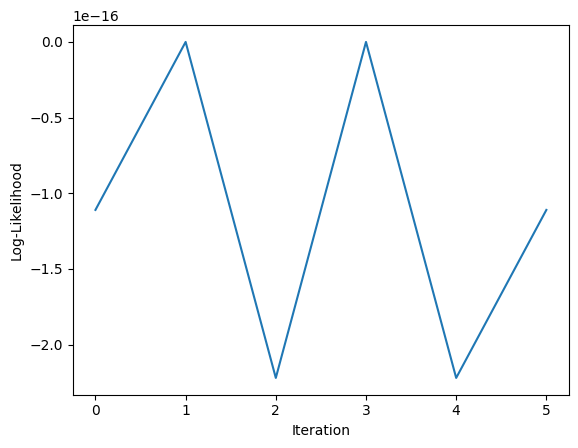

In [ ]:
# log-likelihood 변화 시각화

plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.show()

In [ ]:
train_pred_idx = model.predict(train_data_idx)
train_accuracy = model.accuracy(train_pred_idx, train_tag_idx)
print(f"Train Accuracy: {train_accuracy:.4f}")

Train Accuracy: 0.1046


# **4. Testing**

In [ ]:
test_pred_idx = model.predict(test_data_idx)
test_accuracy = model.accuracy(test_pred_idx, test_tag_idx)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.1034


# **5. Results**

In [ ]:
def compare_result(words, true_tags, pred_indices, tag_to_idx):
  # 1. 인덱스를 태그 이름으로 변환
  idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

  # 2. 예측 결과 출력
  for word, true_tag, pred_idx in zip(words, true_tags, pred_indices):
    true_tag_label = true_tag if isinstance(true_tag, str) else idx_to_tag[true_tag]
    pred_tag_label = idx_to_tag[pred_idx]
    print(f"Word: {word:15} True Tag: {true_tag_label:10} Pred Tag: {pred_tag_label:10}")

In [ ]:
compare_result(train_words[:20], train_tags[:20], train_pred_idx[:20], tag_to_index)

Word: confidence      True Tag: N          Pred Tag: AdJ       
Word: in              True Tag: PP         Pred Tag: PN        
Word: the             True Tag: ART        Pred Tag: N         
Word: pound           True Tag: N          Pred Tag: PN        
Word: is              True Tag: V          Pred Tag: N         
Word: widely          True Tag: AD         Pred Tag: AD        
Word: expected        True Tag: V          Pred Tag: CONJ      
Word: to              True Tag: ETC        Pred Tag: N         
Word: take            True Tag: V          Pred Tag: CONJ      
Word: another         True Tag: ART        Pred Tag: NUM       
Word: sharp           True Tag: AdJ        Pred Tag: ETC       
Word: dive            True Tag: N          Pred Tag: PN        
Word: if              True Tag: PP         Pred Tag: PP        
Word: trade           True Tag: N          Pred Tag: PN        
Word: figures         True Tag: N          Pred Tag: <EOS>     
Word: for             True Tag: PP      

In [ ]:
compare_result(test_words[:20], test_tags[:20], test_pred_idx[:20], tag_to_index)

Word: rockwell        True Tag: N          Pred Tag: AdJ       
Word: international   True Tag: N          Pred Tag: PN        
Word: corp.           True Tag: N          Pred Tag: PP        
Word: 's              True Tag: ETC        Pred Tag: AD        
Word: tulsa           True Tag: N          Pred Tag: CONJ      
Word: unit            True Tag: N          Pred Tag: CONJ      
Word: said            True Tag: V          Pred Tag: CONJ      
Word: it              True Tag: PN         Pred Tag: AdJ       
Word: signed          True Tag: V          Pred Tag: ETC       
Word: a               True Tag: ART        Pred Tag: V         
Word: tentative       True Tag: AdJ        Pred Tag: <EOS>     
Word: agreement       True Tag: N          Pred Tag: AD        
Word: extending       True Tag: V          Pred Tag: PN        
Word: its             True Tag: PN         Pred Tag: N         
Word: contract        True Tag: N          Pred Tag: <EOS>     
Word: with            True Tag: PP      